### 1. Objective & Learning Outcomes

By the end of this notebook, you will understand:

Why KNN is sensitive to feature scale

How k controls bias–variance tradeoff

Why 2D plots lie (and when they help)

How KNN actually makes predictions

How to choose k correctly using cross-validation

Dataset used: Iris (classic, interpretable, multi-class)

### 2. Imports & Global Settings

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10,6)


### 3. Dataset Loading & Basic Inspection

In [9]:
iris = load_iris()

X = iris.data
y = iris.target

feature_names = iris.feature_names
class_names = iris.target_names

df = pd.DataFrame(X, columns=feature_names)
df['species'] = y

df.head()


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


### 4. Understanding the Raw Data

In [10]:
df.describe()


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


🔍 Observations

150 samples, 4 numerical features, 3 classes

Feature scales are very different

Petal length ranges much wider than sepal width

Since KNN uses Euclidean distance, larger-scale features will dominate

Key principle:
Distance-based models require comparable feature scales.

### 5. Pairwise Feature Relationships (Why 2D Can Mislead)

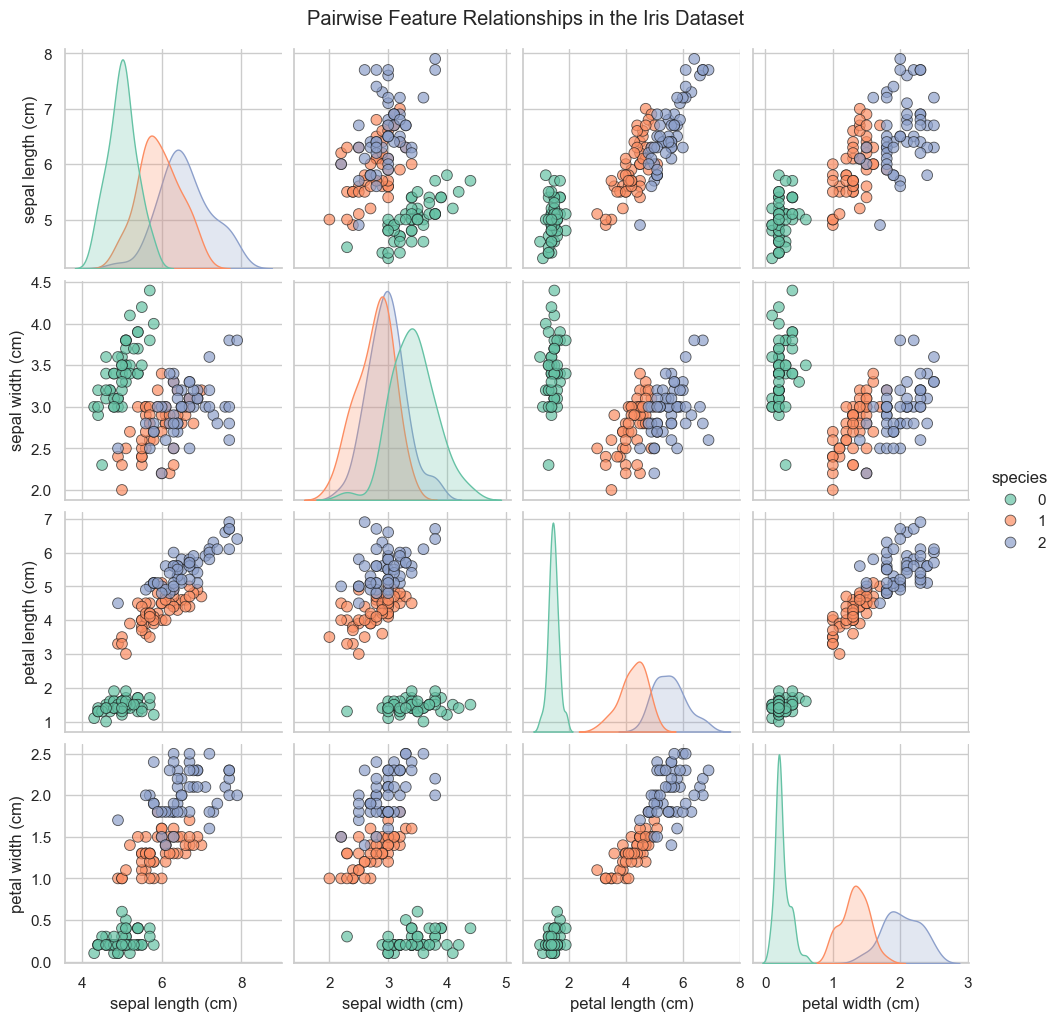

In [27]:
sns.pairplot(
    df,
    hue="species",
    diag_kind="kde",
    palette="Set2",
    plot_kws={'alpha':0.7, 's':60, 'edgecolor':'k'}
)
plt.suptitle("Pairwise Feature Relationships in the Iris Dataset", y=1.02)
plt.savefig('pairplot.png', dpi=300, bbox_inches='tight')
plt.show();


🔍 Observations

Petal features separate classes very well

Sepal features overlap heavily

Any 2D visualization hides useful information present in higher dimensions

Takeaway:
2D plots are for intuition, not for final judgment.

### 6. Train–Test Split (Before Any Scaling)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)


Why split before scaling?

Prevents data leakage

Mimics real-world deployment

### 7. Feature Scaling (Non-Negotiable for KNN)

In [14]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


🔍 Why this is critical

Each feature now contributes equally to distance

Neighbor selection becomes meaningful

Without this step, KNN results are mathematically biased

Rule:
If you skip scaling, you are not really using KNN.

### 8. Visualizing the Effect of Scaling (2D Projection)

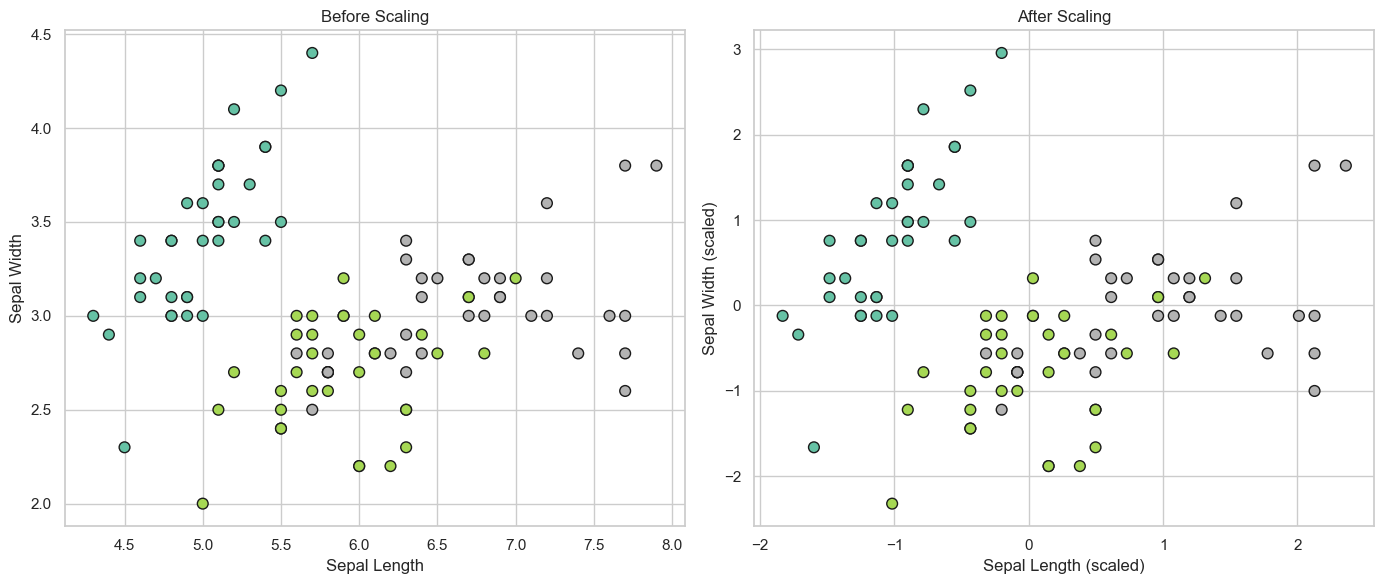

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(14,6))

# Before scaling
axes[0].scatter(
    X_train[:,0], X_train[:,1],
    c=y_train, cmap='Set2',
    edgecolor='k', s=60
)
axes[0].set_title("Before Scaling")
axes[0].set_xlabel("Sepal Length")
axes[0].set_ylabel("Sepal Width")

# After scaling
axes[1].scatter(
    X_train_scaled[:,0], X_train_scaled[:,1],
    c=y_train, cmap='Set2',
    edgecolor='k', s=60
)
axes[1].set_title("After Scaling")
axes[1].set_xlabel("Sepal Length (scaled)")
axes[1].set_ylabel("Sepal Width (scaled)")

plt.tight_layout()

plt.savefig('scaling_comparison_highres.png', dpi=600, bbox_inches='tight')  # Publication quality
plt.savefig('scaling_comparison_web.jpg', dpi=150, bbox_inches='tight')  # Web optimized
plt.savefig('scaling_comparison.pdf', bbox_inches='tight')  # Vector format for editing

plt.show();


🔍 Observation

Geometry of space changes

Distances are no longer dominated by one axis

### 9. Baseline KNN on Scaled Data

In [17]:
knn_5 = KNeighborsClassifier(n_neighbors=5)
knn_5.fit(X_train_scaled, y_train)

print("Train accuracy:", knn_5.score(X_train_scaled, y_train))
print("Test accuracy :", knn_5.score(X_test_scaled, y_test))


,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


Train accuracy: 0.9809523809523809
Test accuracy : 0.9111111111111111


Interpretation

Reasonable generalization

No extreme overfitting

Scaling + moderate k already works well

### 10. Bias–Variance Intuition: Effect of k

In [18]:
k_values = range(1, 21)
train_scores = []
test_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    train_scores.append(knn.score(X_train_scaled, y_train))
    test_scores.append(knn.score(X_test_scaled, y_test))


,n_neighbors,1
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


,n_neighbors,2
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


,n_neighbors,3
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


,n_neighbors,4
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


,n_neighbors,6
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


,n_neighbors,7
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


,n_neighbors,8
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


,n_neighbors,9
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


,n_neighbors,10
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


,n_neighbors,11
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


,n_neighbors,12
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


,n_neighbors,13
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


,n_neighbors,14
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


,n_neighbors,15
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


,n_neighbors,16
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


,n_neighbors,17
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


,n_neighbors,18
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


,n_neighbors,19
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


,n_neighbors,20
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


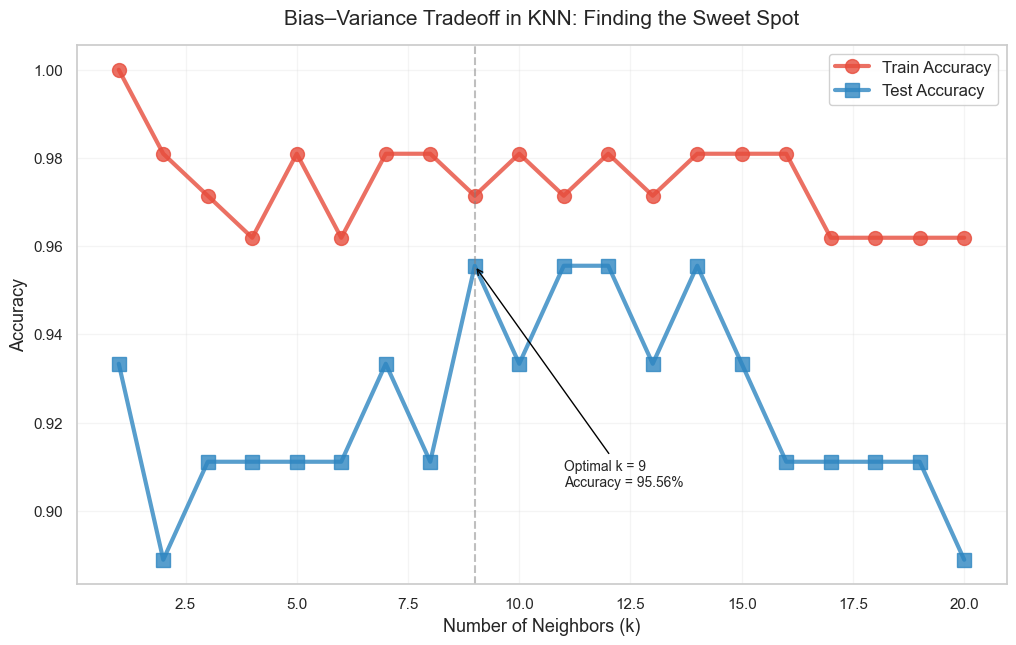

In [32]:
plt.figure(figsize=(12, 7))

# Plot with better styling
plt.plot(k_values, train_scores, marker='o', label='Train Accuracy', 
         linewidth=3, markersize=10, color='#E74C3C', alpha=0.8)
plt.plot(k_values, test_scores, marker='s', label='Test Accuracy', 
         linewidth=3, markersize=10, color='#2E86C1', alpha=0.8)

# Annotate the optimal k point
optimal_k = k_values[np.argmax(test_scores)]
optimal_acc = max(test_scores)
plt.axvline(x=optimal_k, color='gray', linestyle='--', alpha=0.5)
plt.annotate(f'Optimal k = {optimal_k}\nAccuracy = {optimal_acc:.2%}', 
             xy=(optimal_k, optimal_acc), 
             xytext=(optimal_k+2, optimal_acc-0.05),
             arrowprops=dict(arrowstyle='->', color='black'),
             fontsize=10)

plt.xlabel("Number of Neighbors (k)", fontsize=13)
plt.ylabel("Accuracy", fontsize=13)
plt.title("Bias–Variance Tradeoff in KNN: Finding the Sweet Spot", fontsize=15, pad=15)
plt.legend(fontsize=12, framealpha=0.9)
plt.grid(alpha=0.2)

# Save high-quality image
plt.savefig(
    'knn_bias_variance.png',
    dpi=400,
    bbox_inches='tight',
    facecolor='white',
    transparent=False
)
plt.show();

🔍 Interpretation

Small k → low bias, high variance (overfitting)

Large k → high bias, low variance (underfitting)

Optimal k balances both

### 11. Choosing k Using Cross-Validation (Correct Way)

In [20]:
cv_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=5)
    cv_scores.append(scores.mean())

best_k = k_values[np.argmax(cv_scores)]
best_k


14

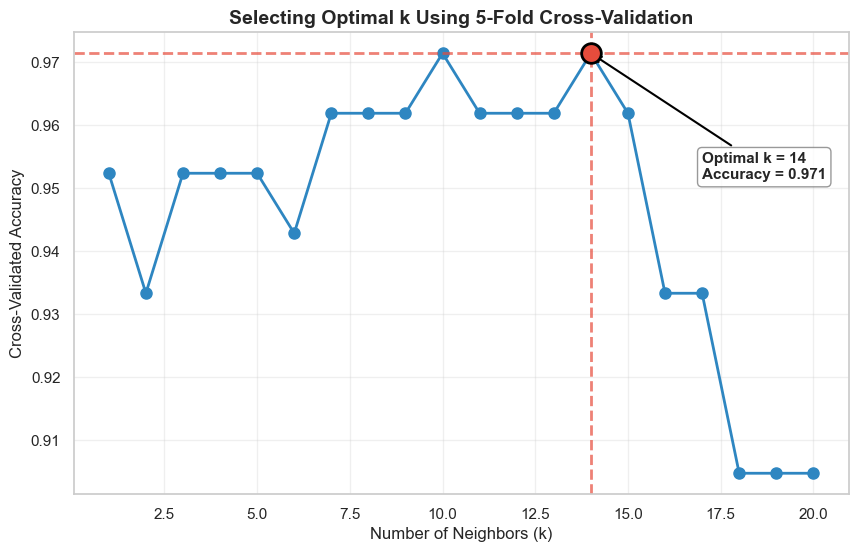

In [36]:
plt.figure(figsize=(10, 6))

# Plot the curve
plt.plot(k_values, cv_scores, marker='o', linewidth=2, markersize=8, color='#2E86C1')

# Highlight the best k
plt.axvline(x=best_k, color='#E74C3C', linestyle='--', alpha=0.7, linewidth=2)
plt.axhline(y=max(cv_scores), color='#E74C3C', linestyle='--', alpha=0.7, linewidth=2)

# Mark the optimal point
plt.scatter(best_k, max(cv_scores), color='#E74C3C', s=200, zorder=5, 
            edgecolor='black', linewidth=2)

# Annotate the optimal point
plt.annotate(f'Optimal k = {best_k}\nAccuracy = {max(cv_scores):.3f}', 
             xy=(best_k, max(cv_scores)), 
             xytext=(best_k+3, max(cv_scores)-0.02),
             arrowprops=dict(arrowstyle='->', color='black', lw=1.5),
             fontsize=11, fontweight='bold',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray", alpha=0.8))

plt.xlabel("Number of Neighbors (k)", fontsize=12)
plt.ylabel("Cross-Validated Accuracy", fontsize=12)
plt.title("Selecting Optimal k Using 5-Fold Cross-Validation", fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)

# Save high-resolution image
plt.savefig('cross_validation_k_selection.png', dpi=400, bbox_inches='tight', facecolor='white')
plt.show();

Why CV matters

Test set should not guide model selection

CV gives stability, not luck

### 12. Final Model with Optimal k

In [22]:
final_knn = KNeighborsClassifier(n_neighbors=best_k)
final_knn.fit(X_train_scaled, y_train)

print("Final Train Accuracy:", final_knn.score(X_train_scaled, y_train))
print("Final Test Accuracy :", final_knn.score(X_test_scaled, y_test))


,n_neighbors,14
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


Final Train Accuracy: 0.9809523809523809
Final Test Accuracy : 0.9555555555555556


### 13. Normalized Confusion Matrix

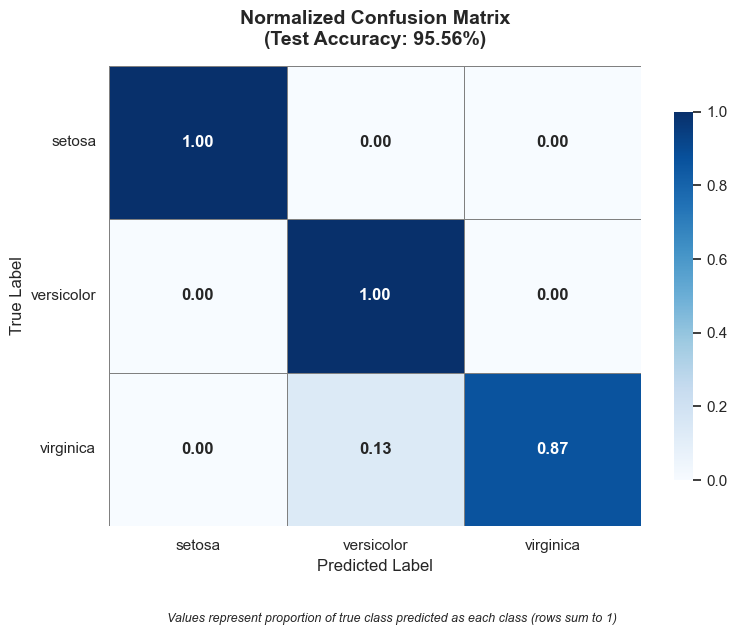

In [37]:
# Calculate confusion matrix
cm = confusion_matrix(
    y_test,
    final_knn.predict(X_test_scaled),
    normalize='true'
)

# Create figure with better dimensions
plt.figure(figsize=(8, 6))

# Create heatmap with better styling
ax = sns.heatmap(
    cm,
    annot=True,
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names,
    fmt='.2f',
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'shrink': 0.8},
    annot_kws={'size': 12, 'weight': 'bold'}
)

# Add title with accuracy if available
accuracy = final_knn.score(X_test_scaled, y_test)
plt.title(f"Normalized Confusion Matrix\n(Test Accuracy: {accuracy:.2%})", 
          fontsize=14, pad=15, fontweight='bold')
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)

# Improve tick labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=11)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=11)

# Add a note about normalization
plt.figtext(0.5, -0.05, 
           "Values represent proportion of true class predicted as each class (rows sum to 1)",
           ha='center', fontsize=9, style='italic')

plt.tight_layout()

# Save high-quality image
plt.savefig('confusion_matrix_normalized.png', 
            dpi=400, 
            bbox_inches='tight', 
            facecolor='white',
            pad_inches=0.2)
plt.show();

Interpretation

Setosa is almost perfectly classified

Errors mostly occur between similar species

This aligns with domain intuition

### 14. How KNN Makes a Prediction (Human Intuition)

In [25]:
nn = NearestNeighbors(n_neighbors=5)
nn.fit(X_train_scaled)

sample = X_test_scaled[0].reshape(1, -1)
distances, indices = nn.kneighbors(sample)


,n_neighbors,5
,radius,1.0
,algorithm,'auto'
,leaf_size,30
,metric,'minkowski'
,p,2
,metric_params,None
,n_jobs,None


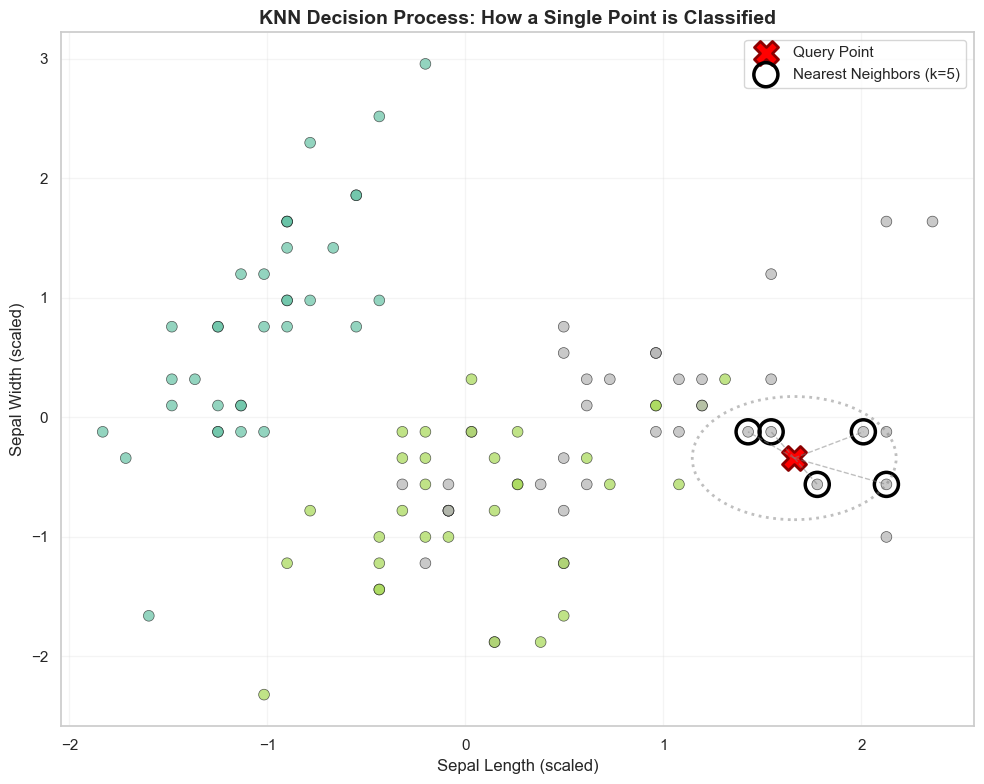

In [40]:
plt.figure(figsize=(10, 8))

# Plot all training points
scatter = plt.scatter(
    X_train_scaled[:,0],
    X_train_scaled[:,1],
    c=y_train,
    cmap='Set2',
    s=60,
    alpha=0.7,
    edgecolor='k',
    linewidth=0.5
)

# Plot query point
query = plt.scatter(
    sample[0,0],
    sample[0,1],
    c='red',
    s=300,
    marker='X',
    label='Query Point',
    edgecolor='darkred',
    linewidth=2
)

# Plot nearest neighbors
neighbors = plt.scatter(
    X_train_scaled[indices[0],0],
    X_train_scaled[indices[0],1],
    facecolors='none',
    edgecolors='black',
    s=300,
    linewidths=2.5,
    label=f'Nearest Neighbors (k={len(indices[0])})'
)

# Add connecting lines from query to neighbors
for i in indices[0]:
    plt.plot([sample[0,0], X_train_scaled[i,0]], 
             [sample[0,1], X_train_scaled[i,1]], 
             'gray', linestyle='--', alpha=0.5, linewidth=1)

# Add circle showing "neighborhood" radius
max_distance = np.max(np.sqrt((sample[0,0] - X_train_scaled[indices[0],0])**2 + 
                              (sample[0,1] - X_train_scaled[indices[0],1])**2))
circle = plt.Circle((sample[0,0], sample[0,1]), max_distance, 
                    color='gray', fill=False, linestyle=':', linewidth=2, alpha=0.5)
plt.gca().add_patch(circle)

plt.title("KNN Decision Process: How a Single Point is Classified", fontsize=14, fontweight='bold')
plt.xlabel("Sepal Length (scaled)", fontsize=12)
plt.ylabel("Sepal Width (scaled)", fontsize=12)
plt.legend(fontsize=11, loc='upper right')
plt.grid(alpha=0.2)

plt.tight_layout()
plt.savefig('knn_prediction_process.png', dpi=900, bbox_inches='tight', facecolor='white')
plt.show();

Core Insight

No training phase in the classical sense

Entire model = stored data

Prediction = majority vote of neighbors

### 15. Conclusion & Hard Truths

### 15. Conclusion & Hard Truths

#### What KNN Really Is

K-Nearest Neighbors is a memory-based learning algorithm.
It does not build an internal model during training. Instead, it stores the entire training dataset and makes decisions only at prediction time by measuring distances between points.

Because of this, KNN is easy to understand and explain, but it becomes computationally expensive as the dataset grows. Every new prediction requires comparing the query point with many stored samples.

#### Common Mistakes to Avoid

- **Feature scaling**: One of the most common mistakes is using KNN without feature scaling. Since KNN relies on distance calculations, unscaled features can completely distort the results and make the model unreliable.

- **Choosing k arbitrarily**: Another frequent mistake is choosing the value of k arbitrarily. A very small k leads to overfitting, while a very large k causes underfitting. The correct approach is to select k using cross-validation, not intuition.

- **Over-reliance on 2D visualizations**: Many learners also place too much trust in 2D visualizations. While they are helpful for intuition, they hide the behavior of the model in higher dimensions where KNN actually operates.

- **Misusing on large datasets**: KNN is often misused on very large datasets, where prediction time becomes slow and inefficient compared to other algorithms.

#### When KNN Makes Sense

KNN works best when:
- The dataset is small to medium in size
- The features represent meaningful distances
- Interpretability is important

It is particularly useful when the data naturally forms clusters and when model transparency is preferred over complex parameter tuning.

#### Final Thought

KNN does not "learn" patterns in the traditional sense.
It reasons using geometry, deciding outcomes based on how close data points are to each other in feature space.

Understanding this simple idea explains both KNN's strengths and its limitations.